## Simple Linear Regression

##### I will use the Boston housing data set, which is contained in the ISLP package. The Boston dataset records medv (median house value) for 506 neighborhoods around Boston. I will build a regression model to predict medv using 13 predictors such as rmvar (average number of rooms per house), age (proportion of owner-occupied units built prior to 1940), and lstat (percent of households with low socioeconomic status)

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)

In [2]:
Boston = load_data('boston')
Boston.head(5)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [3]:
Boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')

##### I start by using the sm.OLS() function to fit a simple linear regression model. Our response will be medv and lstat will be the single predictor.

In [5]:
X = pd.DataFrame({'intercept': np.ones(Boston.shape[0]), 'lstat': Boston['lstat']})
X.head(4)

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94


In [6]:
y = Boston['medv']
model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,34.5538,0.563,61.415,0.0
lstat,-0.9500,0.039,-24.528,0.0


In [7]:
design = MS(['lstat'])
design = design.fit(Boston)
X = design.transform(Boston)
X[:4]

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94


In [8]:
design = MS(['lstat'])
X = design.fit_transform(Boston)
X[:4]

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94


In [9]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Sun, 08 Sep 2024   Prob (F-statistic):           5.08e-88
Time:                        05:47:46   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.5538      0.563     61.415      0.000      33.448      35.659
lstat         -0.9500      0.039    -24.528      0.000      -1.026      -0.874
==============================================================================
Omnibus:                      137.043   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.373
Skew:                           1.453   Prob(JB):                     5.36e-64
Kurtosis:                       5.319   Cond. No.                         29.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
results.params

intercept    34.553841
lstat        -0.950049
dtype: float64

In [11]:
new_df = pd.DataFrame({'lstat': [5, 10, 15]})
newX = design.fit(new_df).transform(new_df)
newX

,intercept,lstat
0,1.0,5
1,1.0,10
2,1.0,15


In [12]:
new_predictions = results.get_prediction(newX)
new_predictions.predicted_mean

array([29.80359411, 25.05334734, 20.30310057])

####  Produce confidence intervals for the predicted values

In [13]:
new_predictions.conf_int(alpha=.05)

array([[29.00741194, 30.59977628],
       [24.47413202, 25.63256267],
       [19.73158815, 20.87461299]])

In [14]:
new_predictions.conf_int(obs= True, alpha=0.05)

array([[17.56567478, 42.04151344],
       [12.82762635, 37.27906833],
       [ 8.0777421 , 32.52845905]])

In [15]:
def abline(ax, b, m, *args, **kwargs):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

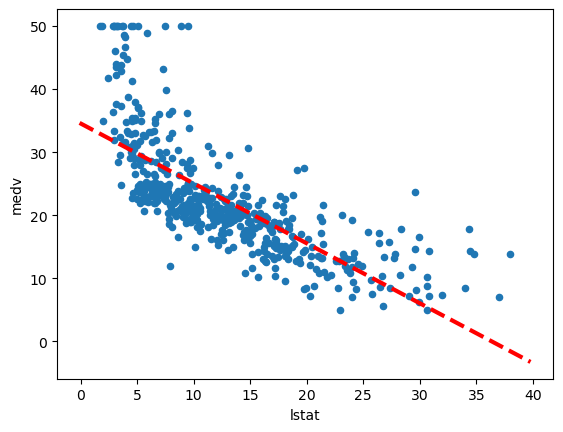

In [35]:
ax = Boston.plot.scatter('lstat', 'medv')
abline(ax, results.params[0], results.params[1], 'r--', linewidth=3)

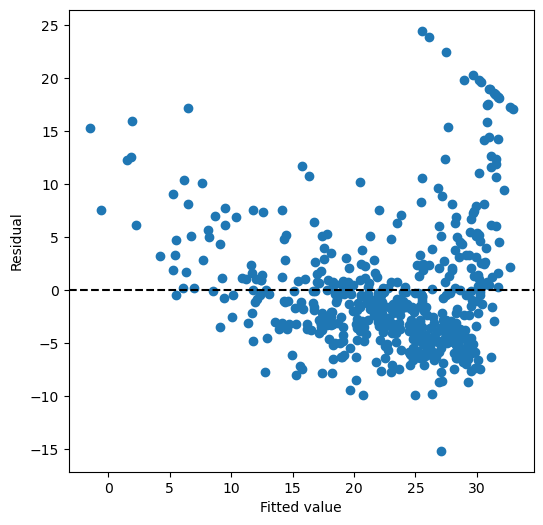

In [16]:
ax = subplots(figsize=(6,6))[1]
ax.scatter(results.fittedvalues , results.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

#### Leverage statistics can be computed for any number of predictors using the hat_matrix_diag attribute of the value returned by the get_influence() method.

374

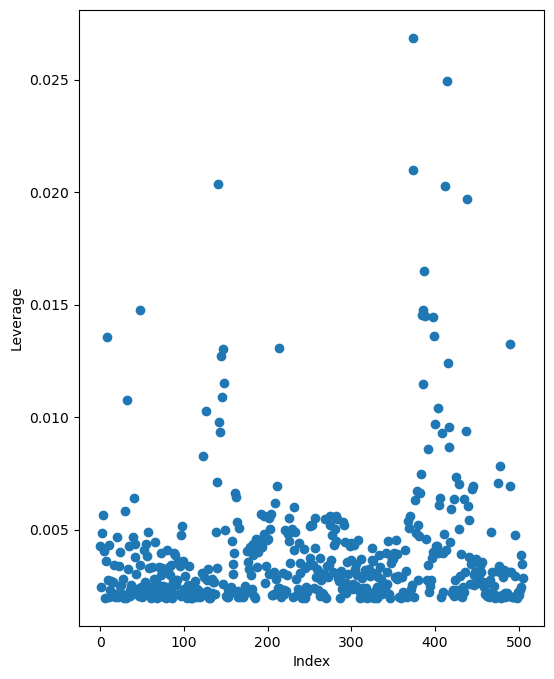

In [17]:
infl = results.get_influence()
ax = subplots(figsize=(6,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)